# K - Nearest Neighbor Classifier

## 1. Introduction

### Import Libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors,KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc,roc_auc_score
import time
import pandas as pd

%matplotlib inline

## 2. Analysis on Sample Data

Generate sample data

In [6]:
def generate_sample(x1_center, x2_center, max_radius, num_samples, ymax=999, ymin=-999):
    i = 0
    x1_list = []
    x2_list = []
    x1_min = x1_center - max_radius
    x1_max = x1_center + max_radius
    x2_min = x2_center - max_radius
    x2_max = x2_center + max_radius
    while i < num_samples:
        x1 = np.random.uniform(x1_min, x1_max)
        x2 = np.random.uniform(x2_min, x2_max)
        mag_data = np.power(x1 - x1_center, 2) + np.power(x2 - x2_center, 2)
        if (
            (mag_data <= np.power(max_radius, 2))
            & (x2 > ymin)
            & (x2 < ymax)
        ):
            x1_list.append(x1)
            x2_list.append(x2)
            i = i + 1
        else:
            continue

    return np.vstack((x1_list, x2_list)).T

In [7]:
x1_centers = [0,0,2]
x2_centers = [0,2,0]
num_data = 50

datas = []
for i in range(0,len(x1_centers)):
    datas.append(generate_sample(x1_centers[i],x2_centers[i],1.5,num_data))
    
X = np.vstack(datas)
y = list(np.hstack([[1] * num_data,[2] * num_data,[3] * num_data]))

(-2.0, 4.0)

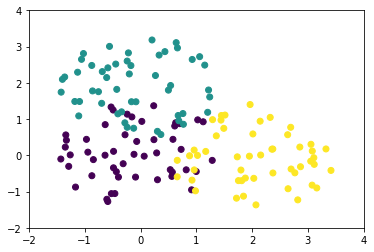

In [8]:
plt.scatter(X[:,0],X[:,1],c=y)
plt.xlim(-2,4);plt.ylim(-2,4)

Initialize kNN Classifier

In [20]:
neigh = NearestNeighbors(n_neighbors=15)
neigh.fit(X,y)

NearestNeighbors(n_neighbors=15)

In [21]:
X_sample = np.array(([0,1],[1,0]))

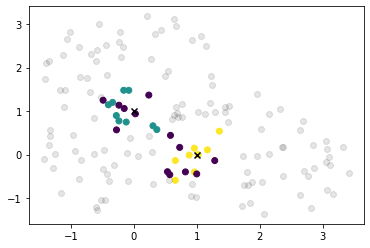

In [22]:
neighbors=neigh.kneighbors(X_sample)
id_arr = neighbors[1]
id_arr = id_arr.flatten().tolist()

arr =  X[id_arr]
y = np.array(y)
arr_y = y[id_arr]
arr_ex = np.array([element for i, element in enumerate(X) if i not in id_arr])

plt.scatter(arr[:,0],arr[:,1],c=arr_y)
plt.scatter(X_sample[:,0],X_sample[:,1],marker='x',c='k')
plt.scatter(arr_ex[:,0],arr_ex[:,1],c='k',alpha=0.1)

In [23]:
neighbors[0]

array([[0.06779211, 0.16636154, 0.27547657, 0.28085443, 0.29913234,
        0.32964258, 0.39466539, 0.43183884, 0.43722765, 0.45374253,
        0.48493271, 0.5056799 , 0.51423694, 0.55053994, 0.56026269],
       [0.02086188, 0.12211008, 0.15053439, 0.19965962, 0.31708292,
        0.31846622, 0.36881271, 0.40460507, 0.43935814, 0.44712261,
        0.60845977, 0.61248631, 0.63297699, 0.64557221, 0.68525139]])

As we see, there are data points that are closer to our sample points compared to other neighbors. Currently, those close data points will have the same vote weight as the one that is farther. We can modify this charactheristic by using euclidean distance as weight factor on majority vote to reflect that closer data points have closer resemblance.

In [24]:
np.array(arr_ex).shape

(120, 2)

### Effect of distance functions

We can use different type of distances function, which may results to different nearest neighbors. For example, let's try using 4 different distances type:  
- Euclidean 
- Minkowski
- Manhattan
- Mahalanobis

C:\Users\madin\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1460: FutureWarning: from version 0.25, pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  warnings.warn("from version 0.25, pairwise_distances for "


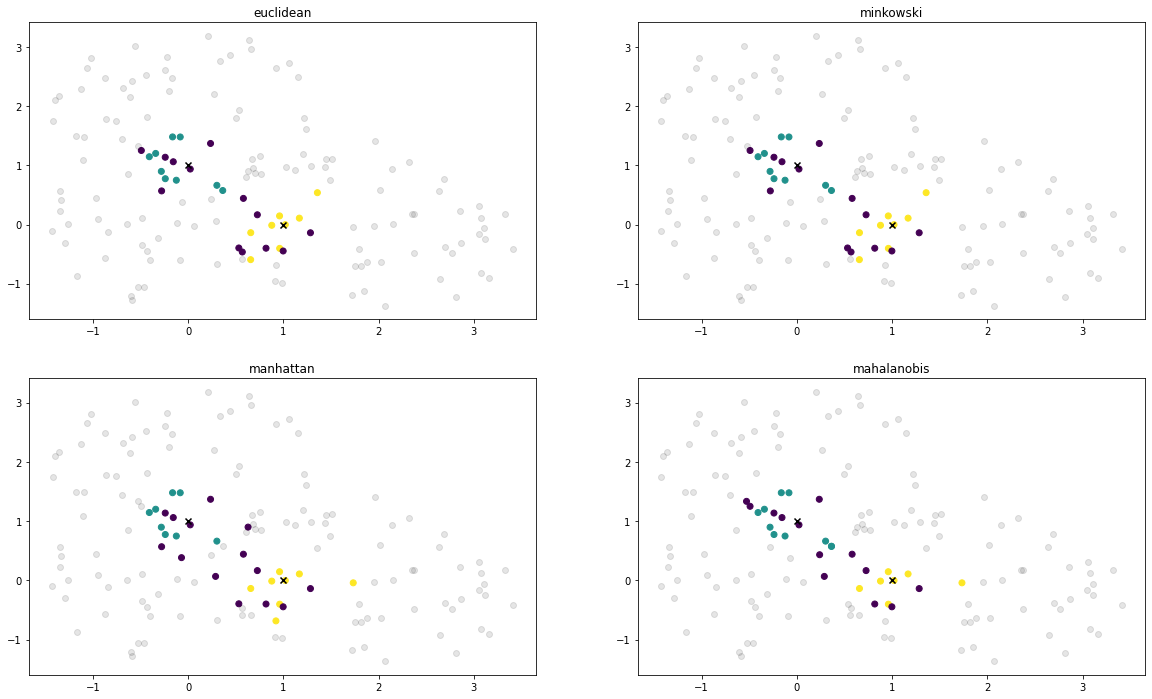

In [41]:
metrictypes=['euclidean','minkowski','manhattan','mahalanobis']
fig, axs = plt.subplots(int(len(metrictypes)/2), 2, figsize=(20, 12))
for i,metrictype in enumerate(metrictypes):
    if(metrictype=='mahalanobis'):
        neigh = NearestNeighbors(n_neighbors=15,algorithm='brute', metric=metrictype,metric_params={'V': np.cov(X)})
    else:
        neigh = NearestNeighbors(n_neighbors=15,metric=metrictype)
    neigh.fit(X,y)
    neighbors=neigh.kneighbors(X_sample)
    id_arr = neighbors[1]
    id_arr = id_arr.flatten().tolist()

    arr =  X[id_arr]
    y = np.array(y)
    arr_y = y[id_arr]
    arr_ex = np.array([element for i, element in enumerate(X) if i not in id_arr])

    axs[int(i/2),i%2].scatter(arr[:,0],arr[:,1],c=arr_y)
    axs[int(i/2),i%2].scatter(X_sample[:,0],X_sample[:,1],marker='x',c='k')
    axs[int(i/2),i%2].scatter(arr_ex[:,0],arr_ex[:,1],c='k',alpha=0.1)
    axs[int(i/2),i%2].set_title(metrictype)

We can see there are changes at the edges point due to how the distance calculated differently

## 3. Usage on real data

Let's try to use KNN Classifier on real world data. Here we have data of usage of fresh product, milk, groceries, frozens, detergents and peper, and delicassen, and whether they are hotels or restaurants. Our objective is to determine with records of these consumables we know whether that is a hotel or restaurant.

In [42]:
df = pd.read_csv('Wholesale customers data.csv')

In [43]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


Select features

In [75]:
X = df[['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']].to_numpy()
y = df[['Channel']].to_numpy().ravel()-1

Split train-test

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Normalize feautures

In [77]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [78]:
X_train=scaler.transform(X_train)

Train model

In [79]:
time_now = time.time()
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train,y_train)
print("Time to fit model {0} ms".format(1000*(time.time()-time_now)))

Time to fit model 1.0335445404052734 ms


In [80]:
time_now = time.time()
y_pred=neigh.predict(X_test)
print("Time to predict {0} ms".format(1000*(time.time()-time_now)))

Time to predict 4.497289657592773 ms


In [81]:
score = 100*(1-np.sum(np.abs(y_pred-y_test))/len(y_test))
print(score)

69.86301369863014


kNN Classifier is a lazy learning method, thus time to fit is relatively slower compared to time to predict. This is contrast to model like logreg, decision tree, or ANN.

Let's compare its performance with logistic regression that we have previously learned

In [82]:
from sklearn.linear_model import LogisticRegression
time_now = time.time()
logreg = LogisticRegression(random_state=123)
logreg.fit(X_train,y_train)
print("Time to fit model {0} ms".format(1000*(time.time()-time_now)))

Time to fit model 3.9892196655273438 ms


In [83]:
time_now = time.time()
y_pred=logreg.predict(X_test)
print("Time to predict {0} ms".format(1000*(time.time()-time_now)))

Time to predict 0.0 ms


In [84]:
score = 100*(1-np.sum(np.abs(y_pred-y_test))/len(y_test))
print(score)

30.136986301369863


Our neighbor classifier works better by miles! Can you guess why this happened? (Hint: Try to remember the concept of linearity and decision boundary)